# Technical Indicators Model

## 1) Introduction
Stock price movement can be predicted using a variety of technical indicators. As we would like to be able to predict whether or not we should buy or sell a stock at a certain time, we could therefore turn to technical indicators to aid us in deciding whether or not buy or sell a stock. 

For this project, we will be using data on historical stock prices and 5 main technical indicators, namely the Simple Moving Average, Exponential Moving Average, Moving Average Convergence/Divergence and the Relative Strength Index, to build a machine learning model that can utilise technical indicators to classify buy and sell signals.

With this model, one could estimate the best times to buy or sell a stock, and hence gain more returns from the market trading AAPL stock.

### Overview:
- Data Preprocessing
    - In this stage, we will remove any redundant columns which might add unneccessary noise to our dataset. We will also ensure all the data is of appropriate data types and ensure no values are missing. In addition, we will also conduct an analysis of our dataset to observe and determine any possible trends in our dataset, as well as create new columns that could be useful in helping us determining buy and sell signals. These would be helpful in ensuring that our machine learning model can be trained effectively and generate accurate buy and sell signals
- Methodology and Experiments
    - In this section, we would train and test a machine learning model using the technical indicators data that we have obtained via preprocessing. From there, we will be able to identify which variable is the most effective at accurately classifying buy and sell signals, and we would then be able experiment with different types of classification models
    - We would also measure their effectiveness using classification metrics such that Accuracy, True Positive Rate, True Negative Rate etc.,  which will allow us to compare the different models we have built and determine the model that is most effective in generating buy and sell signals
- Conclusion
    - Lastly, we will summarize our findings in this project and determine any limitations and possible improvements we could make to our model

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from yahoo_fin import stock_info as sf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier, LogisticRegression

sns.set()
random_state = 1

## 2) Data Preprocessing
The dataset we will be using for this problem will consist of the historical daily stock prices of AAPL from 2015-01-01 to 2019-12-31. The description of the data features are as follows:
- date = Date of trading day
- high = Maximum traded price of AAPL stock on that day
- low = Minimum traded price of AAPL stock on that day
- open = The first traded price of AAPL stock on that day
- close = The last traded price of AAPL stock on that day
- adjclose = Adjusted closing price of the day, after accounting for all applicable splits and dividend distributions
- volume = Number of shares of AAPL stock traded on that day
- ticker = AAPL stock symbol

### 2a) Data Cleaning

In [2]:
stock = 'AAPL'
short_window = 20
medium_window = 50
start_date = '2015-01-01'
end_date = '2019-12-31'

#### Get Stock Data

In [3]:
pre_start_date = dt.date.fromisoformat(start_date) - dt.timedelta(100)  # Buffer data to ensure that all entries after '2015-01-01' are not null after transformation
post_end_date = dt.date.fromisoformat(end_date) + dt.timedelta(1)  # The date range we want must be inclusive on our end_date

stock_df = sf.get_data(ticker=stock, start_date=pre_start_date, end_date=post_end_date, index_as_date=False)
stock_df.to_csv('aapl_stock_raw.csv')
stock_df

,date,open,high,low,close,adjclose,volume,ticker
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962929,253608800,AAPL
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763817,240687200,AAPL
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000,AAPL
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540091,249482000,AAPL
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396908,199065200,AAPL
...,...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800,AAPL
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200,AAPL
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869431,146266000,AAPL
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,AAPL


#### Ensure Appropriate DataTypes no NULL Columns
All columns are of appropriate data types, and there are no NULL columns, so there is no need to make any modifications as of now.

In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1328 non-null   datetime64[ns]
 1   open      1328 non-null   float64       
 2   high      1328 non-null   float64       
 3   low       1328 non-null   float64       
 4   close     1328 non-null   float64       
 5   adjclose  1328 non-null   float64       
 6   volume    1328 non-null   int64         
 7   ticker    1328 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 83.1+ KB


#### Remove Redundant and NULL Columns
The ticker column is a redundant column since every entry is populated with the same value ('AAPL'), hence it might lead to unneccessary noise which could affect our model's accuracy, hence we will remove it from the dataset.

In [5]:
stock_df.drop(columns=['ticker'], inplace=True)
stock_df.dropna(inplace=True)
stock_df

,date,open,high,low,close,adjclose,volume
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962929,253608800
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763817,240687200
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540091,249482000
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396908,199065200
...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869431,146266000
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400


### 2b) Exploratory Data Analysis

#### Analyse Dataset Features

In [6]:
stock_df.describe()

,open,high,low,close,adjclose,volume
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1.328000e+03
mean,37.988712,38.324866,37.662664,38.008274,35.898769,1.470103e+08
std,11.023229,11.122092,10.945773,11.049321,11.303093,7.292002e+07
min,22.500000,22.917500,22.367500,22.584999,20.883036,4.544800e+07
25%,28.399374,28.631875,28.090625,28.386876,25.983143,9.651220e+07
50%,36.120001,36.446251,35.889999,36.162500,34.077675,1.287770e+08
75%,45.790000,46.123126,45.243750,45.714375,44.017084,1.779131e+08
max,72.779999,73.492500,72.379997,73.412498,71.810928,6.488252e+08


#### Get Indicator Data
For this project, I would be focussing on short term (20 days) to medium term (50 days) investing or trading, hence, I must calculate the short and medium term technical indicator data for the Simple Moving Average (SMA), Exponential Moving Average (EMA), Moving Average Convergence/Divergence (MACD) and the Relative Strength Index (RSI):
- SMA = Average close price of AAPL stock in a specified window
- EMA = Weight averaged close price of AAPL stock in a specified window, with more focus on the current price
- MACD = Identifies the momentum of a particular trend, and highlights the relationship between the 12 and 16 day EMAs of AAPL stock price, this is used in tandem with a signal variable, which is the 9 day EMA of MACD
- RSI = Measures the speed and magnitude of AAPL's recent price changes to determines if it is overvalued or undervalued

In [7]:
def getSMA(data, window):
    data[f'sma_{window}'] = data['close'].rolling(window).mean()
    return data

def getEMA(data, window):
    data[f'ema_{window}'] = data['close'].ewm(span=window).mean()
    return data

def getMACD(data):
    data['macd_12'] = data['close'].ewm(span=12).mean()
    data['macd_26'] = data['close'].ewm(span=26).mean()
    data['macd_value'] = data['macd_12'] - data['macd_26']
    data['macd_price_signal'] = data['macd_value'].ewm(span=9).mean()
    data = data.drop(columns=['macd_12', 'macd_26'])
    return data

def getRSI(data, window):
    close_delta = data['close'].diff()
    
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = window - 1, adjust=True, min_periods = window).mean()
    ma_down = down.ewm(com = window - 1, adjust=True, min_periods = window).mean()
        
    data[f'rsi_{window}'] = 100 - (100/(1 + (ma_up / ma_down)))
    return data

In [8]:
# SMA for both short and medium windows
stock_df = getSMA(stock_df, short_window)
stock_df = getSMA(stock_df, medium_window)

# EMA for both short and medium windows
stock_df = getEMA(stock_df, short_window)
stock_df = getEMA(stock_df, medium_window)

# MACD
stock_df = getMACD(stock_df)

# RSI for both short and medium windows
stock_df = getRSI(stock_df, short_window)
stock_df = getRSI(stock_df, medium_window)

stock_df

,date,open,high,low,close,adjclose,volume,sma_20,sma_50,ema_20,ema_50,macd_value,macd_price_signal,rsi_20,rsi_50
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962929,253608800,NaN,NaN,25.660000,25.660000,0.000000,0.000000,NaN,NaN
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763817,240687200,NaN,NaN,25.543187,25.546525,-0.004992,-0.002773,NaN,NaN
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000,NaN,NaN,25.148202,25.172369,-0.036440,-0.016571,NaN,NaN
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540091,249482000,NaN,NaN,25.159547,25.176382,-0.023855,-0.019039,NaN,NaN
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396908,199065200,NaN,NaN,25.127606,25.144177,-0.022881,-0.020182,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800,68.019249,65.16060,68.394995,65.146570,1.656653,1.501481,72.396576,67.190754
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200,68.339499,65.43355,68.783805,65.434057,1.781618,1.557508,75.618908,68.708110
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869431,146266000,68.613999,65.71070,69.132966,65.709192,1.857027,1.617412,75.438087,68.644920
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,68.917374,65.99190,69.489827,65.990400,1.929248,1.679779,76.368056,69.098308


#### Obtain the Difference and Signal for the Respective Indicators
Since indicators like SMA, EMA and MACD indicate buy and sell signals based on whether the short-term trend is greater than than the medium-term trend, we must create a new column to capture the difference between the respective indicators. We will also create a new column to capture the buy or sell signal if the indicator was used individually. Another benefit to this is so that the model will make classifications based on the difference and the individual signals as opposed to the price of AAPL stock.

No new column will be created for RSI since RSI is mainly used as a filter or confirmation for a signal based off other indicators as opposed to an independent signal indicator.

In [9]:
stock_df['sma_diff'] = stock_df['sma_20'] - stock_df['sma_50']
stock_df['sma_signal'] = stock_df['sma_20'] > stock_df['sma_50']

stock_df['ema_diff'] = stock_df['ema_20'] - stock_df['ema_50']
stock_df['ema_signal'] = stock_df['ema_20'] > stock_df['ema_50']

stock_df['macd_diff'] = stock_df['macd_value'] - stock_df['macd_price_signal']
stock_df['macd_signal'] = stock_df['macd_value'] > stock_df['macd_price_signal']

stock_df

,date,open,high,low,close,adjclose,volume,sma_20,sma_50,ema_20,...,macd_value,macd_price_signal,rsi_20,rsi_50,sma_diff,sma_signal,ema_diff,ema_signal,macd_diff,macd_signal
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962929,253608800,NaN,NaN,25.660000,...,0.000000,0.000000,NaN,NaN,NaN,False,0.000000,False,0.000000,False
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763817,240687200,NaN,NaN,25.543187,...,-0.004992,-0.002773,NaN,NaN,NaN,False,-0.003337,False,-0.002219,False
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000,NaN,NaN,25.148202,...,-0.036440,-0.016571,NaN,NaN,NaN,False,-0.024168,False,-0.019869,False
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540091,249482000,NaN,NaN,25.159547,...,-0.023855,-0.019039,NaN,NaN,NaN,False,-0.016835,False,-0.004817,False
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396908,199065200,NaN,NaN,25.127606,...,-0.022881,-0.020182,NaN,NaN,NaN,False,-0.016571,False,-0.002700,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800,68.019249,65.16060,68.394995,...,1.656653,1.501481,72.396576,67.190754,2.858649,True,3.248426,True,0.155172,True
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200,68.339499,65.43355,68.783805,...,1.781618,1.557508,75.618908,68.708110,2.905949,True,3.349748,True,0.224109,True
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869431,146266000,68.613999,65.71070,69.132966,...,1.857027,1.617412,75.438087,68.644920,2.903299,True,3.423775,True,0.239615,True
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,68.917374,65.99190,69.489827,...,1.929248,1.679779,76.368056,69.098308,2.925474,True,3.499427,True,0.249469,True


#### Relationship between AAPL Stock Price and respective Indicators
In general, we can observe the following trends for the technical indicators specified above:
- All 4 indicators follow AAPL's price trend, as seen from how the valule of the indicators and AAPL's stock price usually rise or fall at around the same time
- The shorter-term (20 day) SMA, EMA and RSI are more reactive to changes in AAPL's stock price compared to the longer-term (50 day) SMA, EMA and RSI respectively
- EMA is more reactive to changes in AAPL's stock price, which demonstrates its emphasis on more current prices of AAPL's stock

In [10]:
def plotCandle(data, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_candlestick(
        x = data['date'],
        low = data['low'],
        high = data['high'],
        open = data['open'],
        close = data['close'],
        name = stock.upper(),
    )
    fig.update_layout(xaxis_rangeslider_visible=False, title_text=f'AAPL Stock Price')
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price', secondary_y=False)
    return fig

def plotSignals(fig, data, target, start=start_date, end=end_date, id=0):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    buy_df = data[data[target] == 1]
    sell_df = data[data[target] == 0]
    marker_size = 10
    fig.add_scatter(
        mode='markers',
        x=buy_df['date'],
        y=buy_df['close'],
        marker_symbol='circle',
        marker_color='#00ff44' if id <= 1 else '#005918',
        marker_size=marker_size,
        name='Buy' if id == 0 else 'Target Buy' if id == 1 else 'Predicted Buy',
    )
    fig.add_scatter(
        mode='markers',
        x=sell_df['date'],
        y=sell_df['close'],
        marker_symbol='circle',
        marker_color='#ff0000' if id <= 1 else '#800000',
        marker_size=marker_size,
        name='Sell' if id == 0 else 'Target Sell' if id == 1 else 'Predicted Sell',
    )
    fig.update_layout(title_text='Expected Buy and Sell Signals')
    return fig

def plotIndicators(fig, data, indicators, style, symbol, secondary, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    for indicator in indicators:
        fig.add_trace(
            go.Scatter(
                x = data['date'],
                y = data[indicator],
                line = {
                    'color': style[indicator],
                    'width': 2,
                },
                name = f'{indicator.upper()}',
            ),
            secondary_y = True if secondary else False
        )
    fig.update_layout(title_text=f'Relationship between AAPL Stock Price and {symbol.upper()}')

    if secondary:
        fig.update_yaxes(title_text=symbol.upper(), secondary_y=True)

    return fig

data_figs = []

In [11]:
price_fig = plotCandle(stock_df)
data_figs.append(price_fig)

sma_indicators = ['sma_20', 'sma_50']
sma_style = {
    'sma_20': '#0062ff',
    'sma_50': '#6e00b8',
}
sma_fig = plotCandle(stock_df)
sma_fig = plotIndicators(sma_fig, stock_df, sma_indicators, sma_style, 'SMA', 0)
data_figs.append(sma_fig)

ema_indicators = ['ema_20', 'ema_50']
ema_style = {
    'ema_20': '#0062ff',
    'ema_50': '#6e00b8',
}
ema_fig = plotCandle(stock_df)
ema_fig = plotIndicators(ema_fig, stock_df, ema_indicators, ema_style, 'EMA', 0)
data_figs.append(ema_fig)

macd_indicators = ['macd_value', 'macd_price_signal']
macd_style = {
    'macd_value': '#0062ff',
    'macd_price_signal': '#6e00b8',
}
macd_fig = plotCandle(stock_df)
macd_fig = plotIndicators(macd_fig, stock_df, macd_indicators, macd_style, 'MACD', 1)
data_figs.append(macd_fig)

rsi_indicators = ['rsi_20', 'rsi_50']
rsi_style = {
    'rsi_20': '#0062ff',
    'rsi_50': '#6e00b8',
}
rsi_fig = plotCandle(stock_df)
rsi_fig = plotIndicators(rsi_fig, stock_df, rsi_indicators, rsi_style, 'RSI', 1)
data_figs.append(rsi_fig)

for fig in data_figs:
    fig.show()

#### Get Target Buy and Sell Signals
Since our dataset does not come with any target buy and sell signal, we will have to use well-known trading strategies to determine our target signals. For this project, we will use one of the most popular strategies known to many traders and investors around the world, which is the SMA Crossover strategy. In this strategy:
- Buy signal is generated when the 10-day SMA rises above the 20-day SMA, which indicates that a potential uptrend is underway
- Sell signal is generated when the 10-day SMA falls below the 20-day SMA, which indicates that a potential downtrend is underway

In [12]:
stock_df = getSMA(stock_df, 10)
stock_df['target'] = (stock_df['sma_10'] - stock_df['sma_20']) > 0
stock_df = stock_df.drop(columns=['sma_10'])
stock_df.to_csv('aapl_stock_full.csv')
stock_df

,date,open,high,low,close,adjclose,volume,sma_20,sma_50,ema_20,...,macd_price_signal,rsi_20,rsi_50,sma_diff,sma_signal,ema_diff,ema_signal,macd_diff,macd_signal,target
0,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.962929,253608800,NaN,NaN,25.660000,...,0.000000,NaN,NaN,NaN,False,0.000000,False,0.000000,False,False
1,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.763817,240687200,NaN,NaN,25.543187,...,-0.002773,NaN,NaN,NaN,False,-0.003337,False,-0.002219,False,False
2,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.895771,400368000,NaN,NaN,25.148202,...,-0.016571,NaN,NaN,NaN,False,-0.024168,False,-0.019869,False,False
3,2014-09-26,24.632500,25.187500,24.600000,25.187500,22.540091,249482000,NaN,NaN,25.159547,...,-0.019039,NaN,NaN,NaN,False,-0.016835,False,-0.004817,False,False
4,2014-09-29,24.662500,25.110001,24.657499,25.027500,22.396908,199065200,NaN,NaN,25.127606,...,-0.020182,NaN,NaN,NaN,False,-0.016571,False,-0.002700,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2019-12-24,71.172501,71.222504,70.730003,71.067497,69.517090,48478800,68.019249,65.16060,68.394995,...,1.501481,72.396576,67.190754,2.858649,True,3.248426,True,0.155172,True,True
1324,2019-12-26,71.205002,72.495003,71.175003,72.477501,70.896332,93121200,68.339499,65.43355,68.783805,...,1.557508,75.618908,68.708110,2.905949,True,3.349748,True,0.224109,True,True
1325,2019-12-27,72.779999,73.492500,72.029999,72.449997,70.869431,146266000,68.613999,65.71070,69.132966,...,1.617412,75.438087,68.644920,2.903299,True,3.423775,True,0.239615,True,True
1326,2019-12-30,72.364998,73.172501,71.305000,72.879997,71.290047,144114400,68.917374,65.99190,69.489827,...,1.679779,76.368056,69.098308,2.925474,True,3.499427,True,0.249469,True,True


#### Correlation Matrices
For our project, we will consider a correlation between 0.7 and 1 a high correlation, a correlation between 0.3 and 0.7 medium correlation, and a correlation between 0 and 0.3 a low to no correlation.

According to the correlation table below, which show the correlation of all the columns in our dataset with respect to the target column, we can observe that the correlation between the new difference and signals columns we previously created were of significantly greater correlation compared to the original indicator columns themselves. All of the aforementioned columns are also of medium correlation to the target. Hence, we will use these columns to train our machine learning model in the next stage.

##### For the Entire Dataset

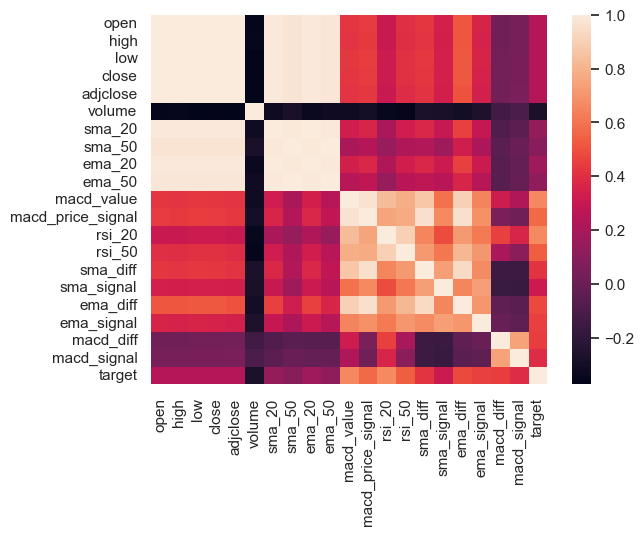

In [13]:
stock_corr = stock_df.corr(numeric_only=True)
sns.heatmap(stock_corr);

##### With Respect to the Target Column

In [14]:
stock_corr_abs = stock_corr.abs()
stock_corr_abs['target'].sort_values(ascending=False)[1:]

rsi_20               0.664626
macd_value           0.656996
macd_price_signal    0.568177
rsi_50               0.533567
ema_diff             0.474351
ema_signal           0.455040
macd_diff            0.446034
sma_diff             0.411804
macd_signal          0.393165
sma_signal           0.309446
volume               0.274407
low                  0.243359
close                0.239448
open                 0.238639
adjclose             0.238289
high                 0.234320
ema_20               0.171871
sma_20               0.137571
ema_50               0.124479
sma_50               0.093666
Name: target, dtype: float64

#### Remove Low to No Correlation Columns
Since all the individual indicator columns (except RSI) and volume column are of low to no correlation to the target, we will remove these columns to minimize unneccessary noise in our data. We will also keep a copy of the full dataset for data visualisation in the later sections

In [15]:
full_stock_df = stock_df.copy()
stock_df = stock_df.drop(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume', 'sma_20', 'sma_50', 'ema_20', 'ema_50'])
stock_df

,date,macd_value,macd_price_signal,rsi_20,rsi_50,sma_diff,sma_signal,ema_diff,ema_signal,macd_diff,macd_signal,target
0,2014-09-23,0.000000,0.000000,NaN,NaN,NaN,False,0.000000,False,0.000000,False,False
1,2014-09-24,-0.004992,-0.002773,NaN,NaN,NaN,False,-0.003337,False,-0.002219,False,False
2,2014-09-25,-0.036440,-0.016571,NaN,NaN,NaN,False,-0.024168,False,-0.019869,False,False
3,2014-09-26,-0.023855,-0.019039,NaN,NaN,NaN,False,-0.016835,False,-0.004817,False,False
4,2014-09-29,-0.022881,-0.020182,NaN,NaN,NaN,False,-0.016571,False,-0.002700,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1323,2019-12-24,1.656653,1.501481,72.396576,67.190754,2.858649,True,3.248426,True,0.155172,True,True
1324,2019-12-26,1.781618,1.557508,75.618908,68.708110,2.905949,True,3.349748,True,0.224109,True,True
1325,2019-12-27,1.857027,1.617412,75.438087,68.644920,2.903299,True,3.423775,True,0.239615,True,True
1326,2019-12-30,1.929248,1.679779,76.368056,69.098308,2.925474,True,3.499427,True,0.249469,True,True


#### Filter the Dataset to Only Include Entries from 2015-01-01 to 2019-12-31
For our project, we will only be focussing on trading days between 2015-01-01 and 2019-12-31, hence we will have to remove other columns whose dates do not lie within this range.

In [16]:
full_stock_df = full_stock_df[start_date <= full_stock_df['date']]
full_stock_df = full_stock_df.reset_index(drop=True)
stock_df = stock_df[start_date <= stock_df['date']]
stock_df = stock_df.reset_index(drop=True)
stock_df.to_csv('aapl_stock_cleaned.csv')
stock_df

,date,macd_value,macd_price_signal,rsi_20,rsi_50,sma_diff,sma_signal,ema_diff,ema_signal,macd_diff,macd_signal,target
0,2015-01-02,-0.054420,0.010108,45.815963,51.201749,0.049325,True,0.201872,True,-0.064528,False,True
1,2015-01-05,-0.159254,-0.023765,40.582154,47.960590,-0.082475,False,0.116552,True,-0.135489,False,True
2,2015-01-06,-0.239371,-0.066886,40.605348,47.971504,-0.198875,False,0.042139,True,-0.172485,False,True
3,2015-01-07,-0.269786,-0.107466,44.031173,49.578887,-0.269650,False,-0.002563,False,-0.162320,False,False
4,2015-01-08,-0.208214,-0.127615,52.110085,53.639699,-0.331425,False,0.014529,True,-0.080598,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2019-12-24,1.656653,1.501481,72.396576,67.190754,2.858649,True,3.248426,True,0.155172,True,True
1254,2019-12-26,1.781618,1.557508,75.618908,68.708110,2.905949,True,3.349748,True,0.224109,True,True
1255,2019-12-27,1.857027,1.617412,75.438087,68.644920,2.903299,True,3.423775,True,0.239615,True,True
1256,2019-12-30,1.929248,1.679779,76.368056,69.098308,2.925474,True,3.499427,True,0.249469,True,True


#### Final Verification of No NULL Values
The final dataset we will be using for training and testing our machine learning model has no null values, and all values are of the right data type.

In [17]:
stock_df.isnull().sum()

date                 0
macd_value           0
macd_price_signal    0
rsi_20               0
rsi_50               0
sma_diff             0
sma_signal           0
ema_diff             0
ema_signal           0
macd_diff            0
macd_signal          0
target               0
dtype: int64

## 3) Methodology

### Split the Dataset into Train and Test Datasets
Since our dataset is a time series data, we will not randomly select 80% of our dataset as our train data, instead, we will select the earliest 80% of our dataset as our train dataset, and use the remaining latest 20% of our dataset as our test dataset. The train dataset will consist of data from 2015-01-01 to 2018-12-31, whereas the test dataset will consist of data from 2019-01-01 to 2019-12-31.

The input will include the following features:
- macd_value
- macd_price_signal
- rsi_20
- rsi_50
- sma_diff
- sma_signal
- ema_diff
- ema_signal
- macd_diff
- macd_signal

The output will be a buy or sell signal:
- 1 = Buy
- 0 = Sell

In [18]:
split_index = int(len(stock_df) * 0.8)

train_data = stock_df[:split_index]
train_data.to_csv('aapl_stock_train.csv')
train_start = train_data.iloc[0].date
train_end = train_data.iloc[-1].date
x_train = train_data.drop(columns=['date', 'target'])
y_train = train_data['target']

test_data = stock_df[split_index:]
test_data.to_csv('aapl_stock_test.csv')
test_start = test_data.iloc[0].date
test_end = test_data.iloc[-1].date
x_test = test_data.drop(columns=['date', 'target'])
y_test = test_data['target']

print(f'''Shape of Train Dataset = {train_data.shape}
Shape of X Train Data = {x_train.shape}
Shape of Y Train Data = {y_train.shape}

Shape of Test Dataset = {test_data.shape}
Shape of X Test Data = {x_test.shape}
Shape of Y Test Data = {y_test.shape}''')

Shape of Train Dataset = (1006, 12)
Shape of X Train Data = (1006, 10)
Shape of Y Train Data = (1006,)

Shape of Test Dataset = (252, 12)
Shape of X Test Data = (252, 10)
Shape of Y Test Data = (252,)


### The RandomForestClassifier Model
Random forest is a popular and powerful ensemble learning method for classification tasks. It is a type of decision tree algorithm that combines the predictions of multiple decision trees to make a final classification decision. The "forest" in random forest is a collection of decision trees, each of which is trained on a random subset of the data and a random subset of the input features. During training, each decision tree is grown using a process called recursive partitioning, where the algorithm splits the data into smaller and smaller subsets based on the values of the input features.

The key idea behind random forests is that by averaging the predictions of multiple decision trees, the final prediction is less sensitive to the noise or variation in any one tree. This helps to reduce overfitting and increase the model's generalization performance. In the case of classification tasks, the final prediction of a random forest is typically determined by majority voting. This means that each tree's prediction is counted as a "vote" for a particular class, and the class with the most votes is chosen as the final prediction.

Lastly, random forest models can provide information about the relative importance of each feature in making the classification decision. This could be useful in feature selections or increasing the interpretability of the model.

#### Obtain HyperParameters for the RandomForestClassifier Model
For a start, we will be using the default hyperparameters for the RandomForestClassifier model.

In [19]:
randfor_model = RandomForestClassifier(n_jobs=-1, random_state=random_state)
randfor_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

#### Train and Test RandomForestClassifier Model
We have chosen to use the RandomForestClassifier Model as our base model due to its ability to model complex decision boundaries by combining the predictions of multiple decision trees. This is particularly useful since the relationship between our dataset's input features and our target variable is non-linear. After fitting the model to our x_train and y_train dataset, we will use the trained model to make predictions based on x_test. Afterwards, we will compare the predicted results with the true target values y_test, and measure the model's effectiveness by calculating the Accuracy, TPR, TNR, FPR and FNR of its prediction.

In [20]:
def train_test_eval(model, x_train, y_train, x_test, y_test, dataset, test_data=full_stock_df, split_index=split_index):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_confmat = confusion_matrix(y_test, model_pred)
    model_confmat_dp = ConfusionMatrixDisplay(model_confmat)
    model_confmat_dp.plot()
    model_confmat_dp.ax_.set_title(f'Confusion Matrix for {type(model).__name__} Model on {dataset} Dataset');

    TN, FP, FN, TP = model_confmat[0][0], model_confmat[0][1], model_confmat[1][0], model_confmat[1][1]
    model_metrics = {
        'Accuracy': (TP + TN) / (TP + FP + TN + FN),
        'TPR': TP / (TP + FN),
        'TNR': TN / (TN + FP),
        'FPR': FP / (FP + TN),
        'FNR': FN / (TP + FN),
    }

    for metric in model_metrics:
        print(f'{metric} = {model_metrics[metric]}')

    if dataset == 'Train':
        test_data = test_data[:split_index].copy()
    else:
        test_data = test_data[split_index:].copy()
    test_data['pred'] = model_pred
    test_fig = plotCandle(test_data)
    test_fig = plotSignals(test_fig, test_data, 'target', id=1)
    test_fig = plotSignals(test_fig, test_data, 'pred', id=2)
    test_fig.update_layout(title_text=f'True VS Predicted Buy and Sell Signals on {dataset} Dateset for {type(model).__name__}')

    return model_metrics, model_confmat, model_pred, test_fig

train_results = {}
test_results = {}

##### RandomForestClassfier Training Results
The RandomForestClassfier model seems to have exactly fit our training dataset, giving us an accuracy score of 1, true positive rate of 1 and true negative rate of 1.

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


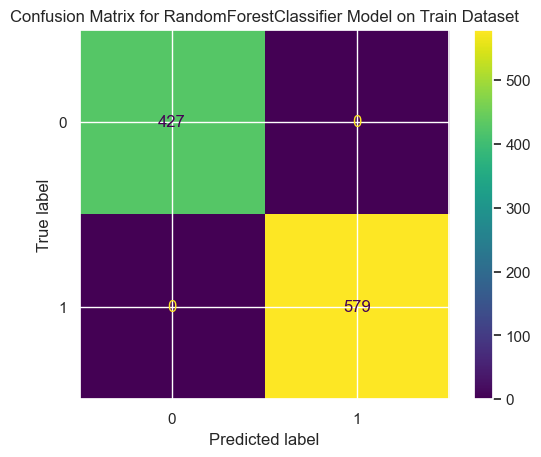

In [21]:
randfor_train_metrics, randfor_train_confmat, randfor_train_pred, randfor_train_fig = train_test_eval(randfor_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(randfor_model).__name__}'] = randfor_train_metrics
randfor_train_fig.show()

##### RandomForestClassifier Test Results
Our RandomForestClassfier model has achived a high prediction accuracy of 0.94, a high true positive rate of 0.9423, a high true negative rate of 0.93182, a low false positive rate of 0.068182 and a low false negative rate of 0.057692 on our test dataset.

Accuracy = 0.9404761904761905
TPR = 0.9423076923076923
TNR = 0.9318181818181818
FPR = 0.06818181818181818
FNR = 0.057692307692307696


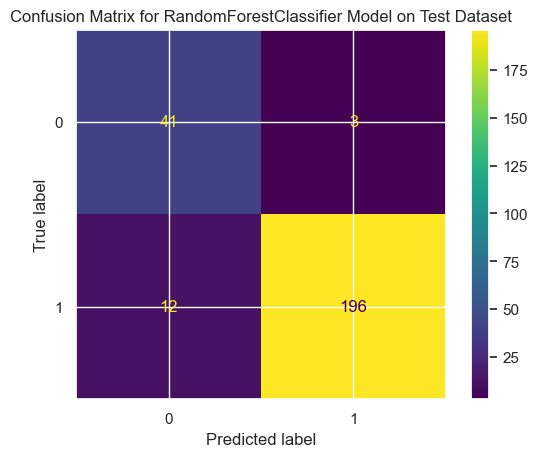

In [22]:
randfor_test_metrics, randfor_test_confmat, randfor_test_pred, randfor_test_fig = train_test_eval(randfor_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(randfor_model).__name__}'] = randfor_test_metrics
randfor_test_fig.show()

##### Identify Important Features in Making the Classification Decisions
It seems the most important variables that the model used to classify the buy and sell decisions were the macd_value and macd_price_signal values.

In [23]:
randfor_impt = dict(zip(x_train.columns, randfor_model.feature_importances_))
for feat in randfor_impt:
    print(f'{feat} = {randfor_impt[feat]}')

macd_value = 0.2794868258586775
macd_price_signal = 0.14909256603429905
rsi_20 = 0.16279918335841267
rsi_50 = 0.08590189733584938
sma_diff = 0.09150966686239385
sma_signal = 0.01064606301336429
ema_diff = 0.07160630285660696
ema_signal = 0.012660901106319141
macd_diff = 0.10610656409627756
macd_signal = 0.03019002947779959


## 4) Experiments
For our experiments, we will be experimenting with 3 different classification models:
- DecisionTreeClassifier
- SGDClassifier
- LogisticRegression

We will also be using the following metrics to measure the effectiveness of our experiments and compare them with our baseline RandomForestClassifier model:
- Accuracy = Proportion of predictions that are correctly predicted as True and correctly predicted as False = (TP + TN) / (TP + TN + FP + FN)
- TPR = The probability that an actual positive will be predicted as positive = (TP / (TP + FN))
- TNR = The probability that an actual negative will be predicted as negative = (TN / (TN + FP))
- FPR = The probability that an actual negative will be predicted as positive = (FP / (FP + TN))
- FNR = The probability that an actual positive will be predicted as negative = (FN / (TP + FN))

### The DecisionTreeClassifier Model
The DecisionTreeClassifier is a classification algorithm that belongs to the family of tree-based models. It builds a decision tree by recursively splitting the data into subsets based on the values of different input features, and then assigning a label to each subset based on the majority class within it. This process is repeated until all instances in the data have been assigned a label. The algorithm works by selecting the best feature to split the data based on some criteria (such as information gain or Gini impurity) at each node. This process is repeated for each resulting subset until a stopping criterion is met, such as reaching a minimum number of instances in a leaf node or a maximum depth for the tree.

The advantage to this model is its ability to use different subsets of features by breaking down complex data into smaller parts, as well as utilise different rules in making its decisions at different stages of classification. This could be particularly useful if the data has a large amount of data and a high number of highly-correlated variables that could significantly affect the model's ability to make decisions.

Overall, the DecisionTreeClassifier is a powerful and interpretable model that can handle both categorical and continuous input features. It can also handle missing values, although some techniques such as imputation may need to be used to handle these missing values.

#### Obtain HyperParameters for DecisionTreeClassifier Model
We will first be using the default hyperparameters for the DecisionTreeClassifier model.

In [24]:
dectree_model = DecisionTreeClassifier(random_state=random_state)
dectree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

#### Train and Test DecisionTreeClassifier Model
The DecisionTreeClassifier model is a possible model we could use since our dataset consists of quite a number of variables that are medium to highly correlated to our target buy or sell signal.

##### DecisionTreeClassifier Training Results
The DecisionTreeClassifier model seems to exactly fit our training dataset and achieved a prediction accuracy 1.0, true positive rate of 1, and a true negative rate of 1.

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


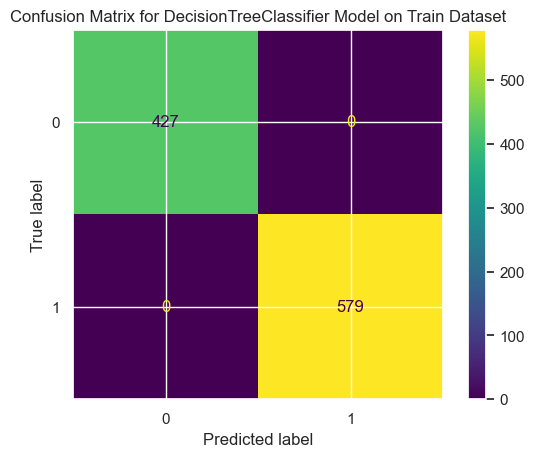

In [25]:
dectree_train_metrics, dectree_train_confmat, dectree_train_pred, dectree_train_fig = train_test_eval(dectree_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(dectree_model).__name__}'] = dectree_train_metrics
dectree_train_fig.show()

##### DecisionTreeClassifier Test Results
The DecisionTreeClassifier model has achieved a high prediction accuracy of 0.91667, a high true positive rate of 0.92788, a high true negative rate of 0.86364, a low false positive rate of 0.13636 and a low false negative rate of 0.072115 on our test dataset.

Accuracy = 0.9166666666666666
TPR = 0.9278846153846154
TNR = 0.8636363636363636
FPR = 0.13636363636363635
FNR = 0.07211538461538461


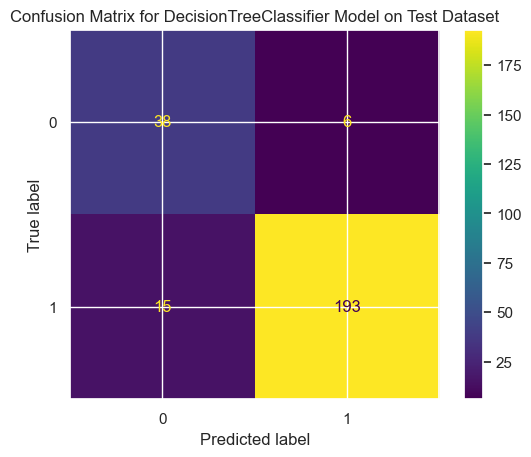

In [26]:
dectree_test_metrics, dectree_test_confmat, dectree_test_pred, dectree_test_fig = train_test_eval(dectree_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(dectree_model).__name__}'] = dectree_test_metrics
dectree_test_fig.show()

#### Visualise the DecisionTreeClassifier Model
This allows us to visualise exactly how this model makes it decisions and classifies the data into a buy or a sell signal.

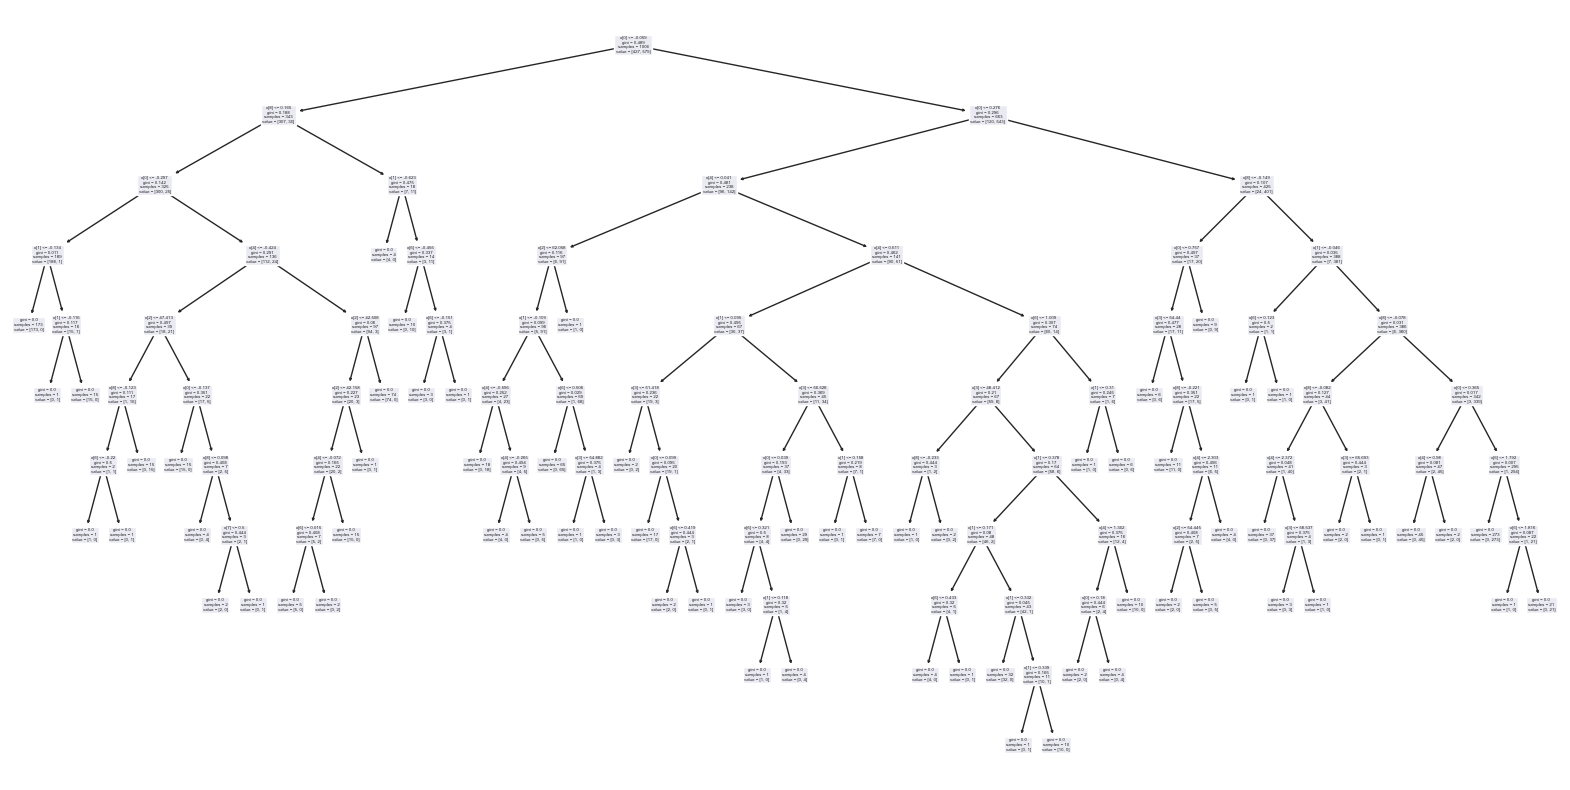

In [27]:
plt.figure(figsize=(20, 10))
plot_tree(dectree_model);

### The SGDClassifier Model
SGDClassifier stands for Stochastic Gradient Descent Classifier. It is a linear classifier that is trained using stochastic gradient descent. This means that during the training process, the model updates its parameters based on small batches of training data instead of the entire dataset at once. It supports different loss functions, such as hinge loss (for linear SVM) and log loss (for logistic regression), and it can handle both binary and multiclass classification problems effectively as well.

The main advantage of this model is its efficiency in large-scale and sparse datasets, as well as its ability to handle high-dimensional data with ease. 

#### Obtain HyperParameters for SGDClassifier Model
We will first be using the default hyperparameters for the SGDClassifier model.

In [28]:
sgd_model = SGDClassifier(n_jobs=-1, random_state=random_state)
sgd_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Train and Test SGDClassifier Model
Since our dataset is has many data features, this model would be able to fit onto our data more effectively and efficienctly compared to other models, which could lead to strong classification ability.

##### SGDClassifier Training Results
This model has managed to achieve a decent prediction accuracy of 0.84592, a decent true positive rate of 0.87565, a decent true negative rate of 0.80562, a low false positive rate of 0.19438 and a low false negative rate of 0.12435 on our train dataset.

Accuracy = 0.8459244532803181
TPR = 0.8756476683937824
TNR = 0.8056206088992974
FPR = 0.19437939110070257
FNR = 0.12435233160621761


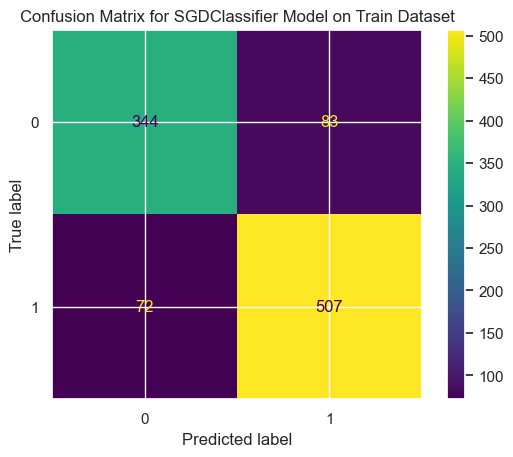

In [29]:
sgd_train_metrics, sgd_train_confmat, sgd_train_pred, sgd_train_fig = train_test_eval(sgd_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(sgd_model).__name__}'] = sgd_train_metrics
sgd_train_fig.show()

##### SGDClassifier Test Results
Our model has managed to achieve a high prediction accuracy of 0.94444, a high true positive rate of 0.96154, a high true negative rate of 0.86364, a low false positive rate of 0.13636 and a low false negative rate of 0.038462 on our test dataset.

Accuracy = 0.9444444444444444
TPR = 0.9615384615384616
TNR = 0.8636363636363636
FPR = 0.13636363636363635
FNR = 0.038461538461538464


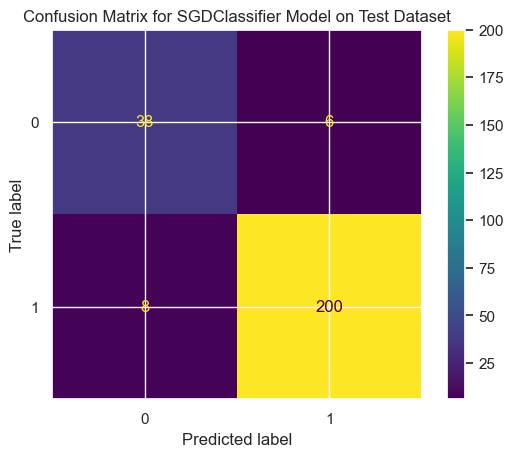

In [30]:
sgd_test_metrics, sgd_test_confmat, sgd_test_pred, sgd_test_fig = train_test_eval(sgd_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(sgd_model).__name__}'] = sgd_test_metrics
sgd_test_fig.show()

### The LogisticRegression Model
LogisticRegression is a linear model that is used for binary classification. It uses the logistic function (also known as sigmoid function) to predict the probability of an input sample belonging to the positive class. The logistic function maps any input value to a value between 0 and 1, which represents the probability of the positive class. 

The main advantage of this model is its interpretability, as it provides the coefficients of the input features, which can be used to interpret the importance of each feature in the classification task.

#### Obtain HyperParameters for LogisticRegression Model
We will first be using the default hyperparameters for the LogisticRegression model.

In [31]:
logreg_model = LogisticRegression(n_jobs=-1, random_state=random_state)
logreg_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Train and Test LogisticRegression Model
The LogisticRegression model could be beneficial since it is a model designed for binary classification, and we only have binary target results, buy and sell. In addition, our data has many medium to high correlation features, so this model could help us to identify which features are more important and affect the decision making process in classifying a buy or sell signal.

##### LogisticRegression Training Results
The model has managed to achieve a high prediction accuracy of 0.91451, a high true positive rate of 0.92223, a high true negative rate of 0.903981, a low false positive rate of 0.096019 and a low false negative rate of 0.077720 on our train dataset.

Accuracy = 0.9145129224652088
TPR = 0.9222797927461139
TNR = 0.9039812646370023
FPR = 0.09601873536299765
FNR = 0.07772020725388601


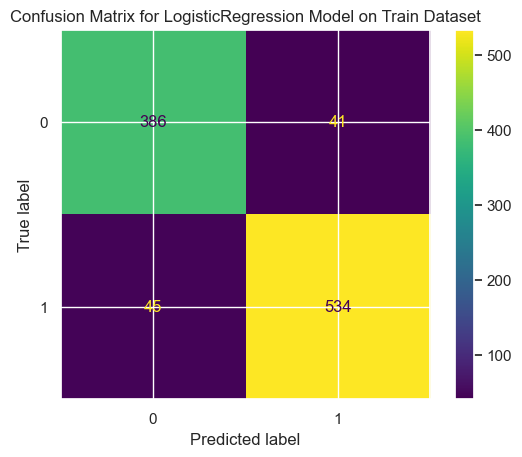

In [32]:
logreg_train_metrics, logreg_train_confmat, logreg_train_pred, logreg_train_fig = train_test_eval(logreg_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(logreg_model).__name__}'] = logreg_train_metrics
logreg_train_fig.show()

##### LogisticRegression Test Results
The model has managed to achieve a high prediction accuracy of 0.95635, a high true positive rate of 0.96154, a high true negative rate of 0.93182, a low false positive rate of 0.06818 and a low false negative rate of 0.038462 on our test dataset.

Accuracy = 0.9563492063492064
TPR = 0.9615384615384616
TNR = 0.9318181818181818
FPR = 0.06818181818181818
FNR = 0.038461538461538464


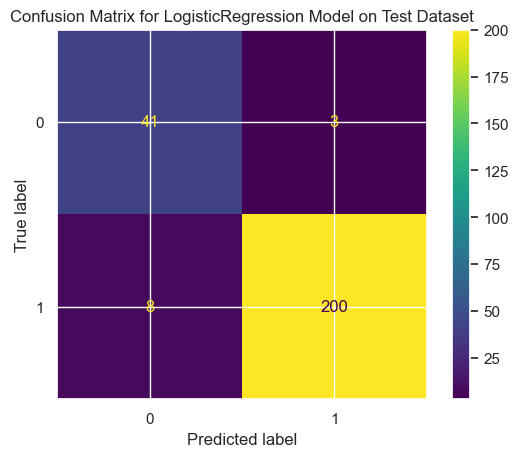

In [33]:
logreg_test_metrics, logreg_test_confmat, logreg_test_pred, logreg_test_fig = train_test_eval(logreg_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(logreg_model).__name__}'] = logreg_test_metrics
logreg_test_fig.show()

### Compare the Performance of our 4 Models

#### Compare the Training Performance
Overall, all our models have managed to fit well on our train dataset, with RandomForestClassifier and DecisionTreeClassifier having fit the train dataset exactly.

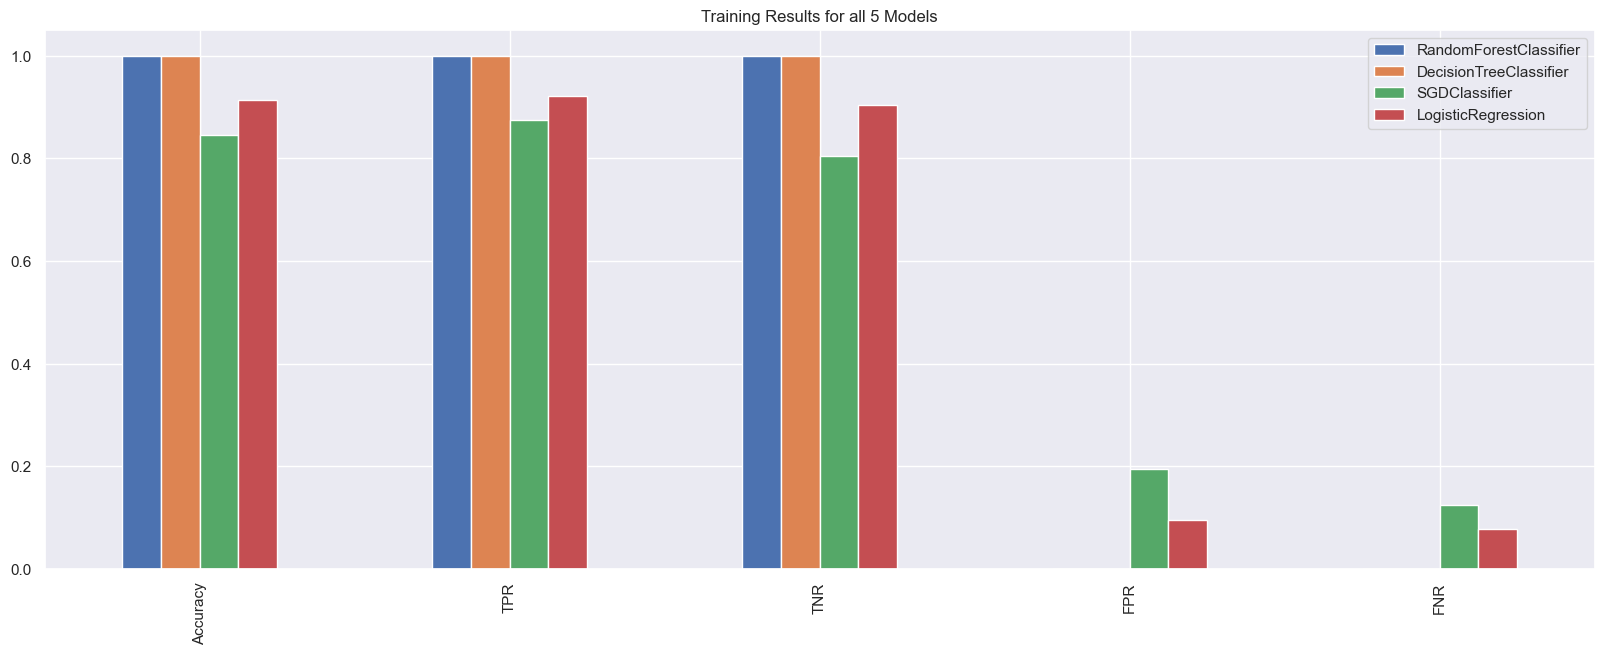

In [34]:
train_results = pd.DataFrame(train_results)
train_results.plot.bar(figsize=(20, 7), title='Training Results for all 5 Models');

#### Compare the Test Performance
In the end, all our models managed to achieve a prediction accuracy of at least 0.92, which is a fantastic result as it highlights on all our models' strong predictio ability. However, the LogisticRegression model had the highest prediction accuracy, true positive rate and true negative rate, and has the lowest false positive rate and false negative rate compared to the other 3 models, hence I would consider it the best model that we have built at this moment. 

Another noteworthy observation that I have made, is that although the RandomForestClassifier and DecisionTreeClassifier managed to fit our train dataset more effectively compared to the other 2 models, they did not perform as well as the other 2 during testing. Hence they could possibly be overfitted, which hindered their ability to predict well on new data like our test dataset.

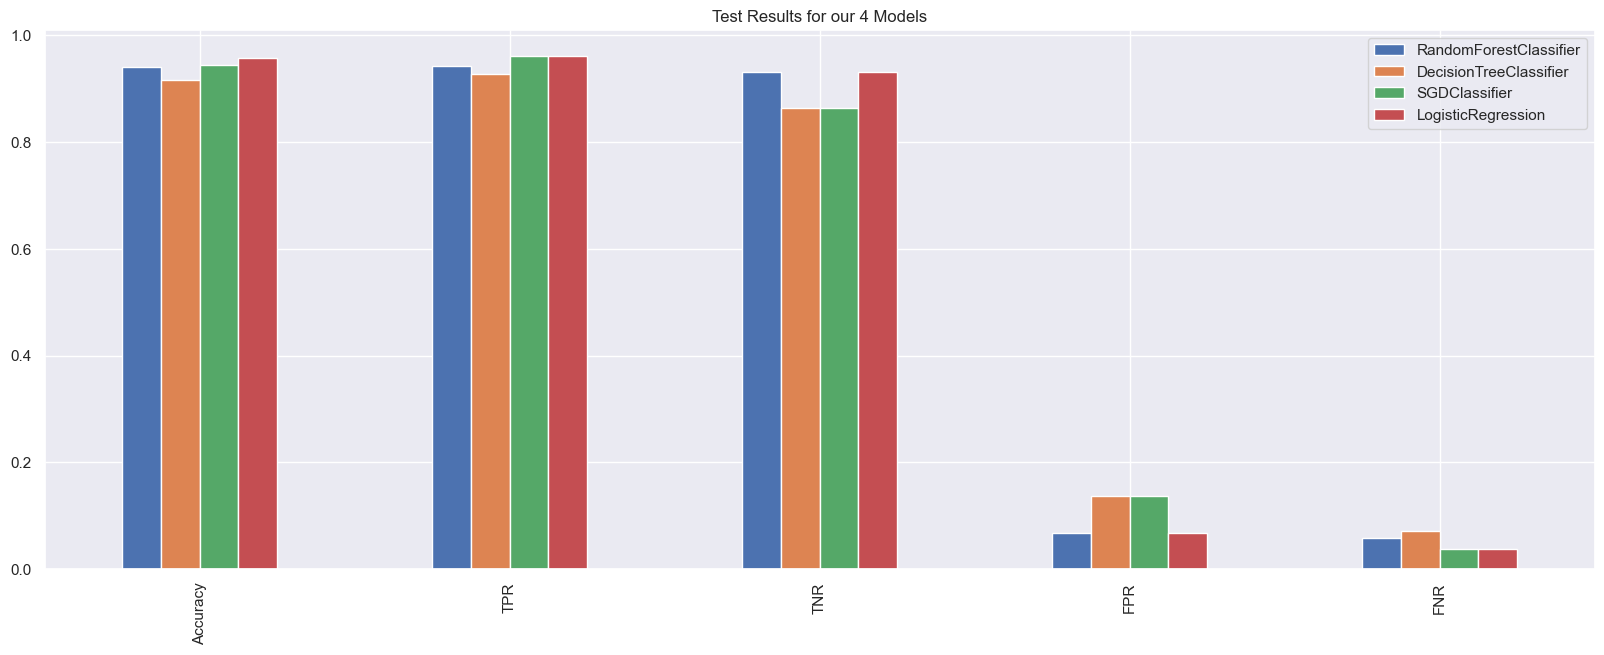

In [35]:
test_results = pd.DataFrame(test_results)
test_results.plot.bar(figsize=(20, 7), title='Test Results for our 4 Models');

## 5) Conclusion